## Equations for kinematic movements
We can model the gestures movements using regular kinematic (Newton's) equations.  

$
\left[
   \begin{array}{l}
    p = p_{o} + v_{o}*t + \dfrac{a t^2}{2}
    \\
    v = v_{o} + at
    \end{array}
\right.
$  

#### where:
- t is time ;
- p is current position ;  
- $p_o$ is the initial position (at time $t_o$)
- v is the velocity ;  
- $v_o$ is the initial velocity ;
- a is the acceleration


We assume the movement as a markovian process, so the current state depends only on the previous state.

Position information should be measured from the samples and velocity can be computed once we define the time step information.

$
\left\{
   \begin{array}{l}
        p_t = p_{t-1} + v_{t-1}*\Delta t + \dfrac{a_{t-1}*\Delta t^2}{2}
        \\
        v_t = v_{t-1} + a_{t-1}* \Delta t 
    \end{array}
\right.
$  

where the subscripts $t$ and $t-1$ indicates respetively the current and previous states ;


As "a" (acceleration) is the second derivative of x (position), we would need two consecutive time steps to compute acceleration.
In our case, be can assume there is no accelaration as there is no external forces acting on the system and the gestures moves with constant velocity. Any variations on the speed will be accounted by the additive noise factors.

This simplifies our equations to:

$
\left\{
   \begin{array}{l}
        x_t = x_{t-1} + v_{t-1}*\Delta t 
        \\
        v = v_{t-1} = \dfrac{\partial x}{\partial t} = \dot x
     \end{array}
\right.
$

also,

$  
\left\{
v = \dfrac{\partial x}{\partial t} = \dot x
\right.
$

       
        

## State Variables

Our state can be fully defined only by two variables: position (x) and velocity (v)

$
x =  
 \begin{vmatrix}
      position \\
      velocity\\
 \end{vmatrix} 
 =
 \begin{vmatrix}
    x \\
    v
 \end{vmatrix} 
 =
 \begin{vmatrix}
    x \\
    \dot{x}
 \end{vmatrix}
$


##  State Space Model  

The movement (our dynamic process) can be written in the matricial form:

\begin{equation}
\left[
    \begin{array}{l}
        x\\
        \dot x
    \end{array}    
\right]
=
\left[
    \begin{array}{ll}
        1 & \Delta t \\
        0 & 1
    \end{array}    
\right]
\left[
    \begin{array}{l}
        x_{t-1}\\
        \\
        \dot x_{t-1}
    \end{array}    
\right]
+
\left[
    \begin{array}{l}
        \dfrac{{\Delta t}^2}{2} \\
        \Delta t
    \end{array}    
\right]
 u
\end{equation}

which is:

$ x_{t} = A x_{t-1}  + Bu $


## Observation model  

We can also write the observation model in a matricial form

$
\left[
    \begin{array}{l}
        Z_x
    \end{array}    
\right]
=
\left[
    \begin{array}{ll}
        1 & 0
    \end{array}    
\right]
\left[
    \begin{array}{ll}
        x_{t}\\
        \dot x_{t}
    \end{array}    
\right]
+
w
$

which is:

$
z_{t} = D x_{t}  + w
$
#### where
- $z_t$ is the observed state
- $w$ is the measurement error: white gaussian $~N(0,Q)$

It is easy to see that the observation model depends only on the position (effectively measured) and we cannot measure the velocity independently (we don't have speed sensors attached to the hands).

In [1]:
import cv2
kf = cv2.KalmanFilter(dynamParams=6, measureParams=3, controlParams=0, type=cv2.CV_64FC1)

## Parse the MKR file and get the dataset (full and center of mass):

In [2]:
#################################
# Intitialization and dependencies
import pandas as pd
import numpy as np
import sympy as sp
import cv2
from MarkerFileParser import MarkerFileParser
from sympy import init_printing
init_printing() 
%matplotlib inline
#################################

In [3]:
mkr = MarkerFileParser('gestures_clean/17-alex-RH/FlipPage1_243260992.mkr')
d = mkr.getDataSet()

In [4]:
c = mkr.getCenterofMass('left')
c.head()

,x,y,z,v
frames,,,,
0,-196.575596,69.243634,47.954311,0.9375
1,-196.591480,69.267866,47.950594,0.9375
2,-196.611049,69.295178,47.960206,0.9375
3,-196.595546,69.277409,47.943891,0.9375
4,-196.615379,69.292064,47.923321,0.9375


In [13]:
dt = mkr.getDeltaT()
#dt = 0.0001

kf.transitionMatrix = np.array([[1, 0, 0, dt, 0, 0],
                                [0, 1, 0, 0, dt, 0],
                                [0, 0, 1, 0, 0, dt],
                                [0, 0, 0, 1, 0, 0],
                                [0, 0, 0, 0, 1, 0],
                                [0, 0, 0, 0, 0, 1]
                               ],dtype="float64")



kf.processNoiseCov = np.array([[(dt**4)/4, 0, 0, (dt**3)/2, 0, 0],
                              [0, (dt**4)/4 , 0, 0, (dt**3)/2, 0],
                              [0, 0, (dt**4)/4, 0, 0, (dt**3)/2],
                              [(dt**3)/2, 0, 0, (dt**2), 0, 0],
                              [0, (dt**3)/2, 0, 0, (dt**2), 0],
                              [0, 0, (dt**3)/2, 0, 0, (dt**2)]
                     ], dtype="float64")


#kf.processNoiseCov = np.array([[0, 0, 0, 0, 0, 0],
#                               [0, 0, 0, 0, 0, 0],
#                               [0, 0, 0, 0, 0, 0],
#                               [0, 0, 0, 1, 0, 0],
#                               [0, 0, 0, 0, 1, 0],
#                               [0, 0, 0, 0, 0, 1]
#                              ],dtype="float64")



kf.measurementMatrix = np.array([[1, 0, 0, 0, 0, 0],
                                 [0, 1, 0, 0, 0, 0],
                                 [0, 0, 1, 0, 0, 0]
                                ],dtype="float64")

kf.measurementNoiseCov = np.array([[1, 0, 0],
                                   [0, 1, 0],
                                   [0, 0, 1,]
                                ],dtype="float64")*1E-6


print "Delta T:", dt

print "Transition:"
print kf.transitionMatrix

print "Measurement:"
print kf.measurementMatrix

print "Control:"
print kf.controlMatrix

print "Process Noise Cov:"
print kf.processNoiseCov

print "Measurement Noise Cov:"
print kf.measurementNoiseCov

print "Error Cov Pre"
print kf.errorCovPre

print "Error Cov Post"
print kf.errorCovPost

Delta T: 0.00833
Transition:
[[ 1.       0.       0.       0.00833  0.       0.     ]
 [ 0.       1.       0.       0.       0.00833  0.     ]
 [ 0.       0.       1.       0.       0.       0.00833]
 [ 0.       0.       0.       1.       0.       0.     ]
 [ 0.       0.       0.       0.       1.       0.     ]
 [ 0.       0.       0.       0.       0.       1.     ]]
Measurement:
[[ 1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]]
Control:
None
Process Noise Cov:
[[  1.20370486e-09   0.00000000e+00   0.00000000e+00   2.89004769e-07
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   1.20370486e-09   0.00000000e+00   0.00000000e+00
    2.89004769e-07   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   1.20370486e-09   0.00000000e+00
    0.00000000e+00   2.89004769e-07]
 [  2.89004769e-07   0.00000000e+00   0.00000000e+00   6.93889000e-05
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   2.89004769e-07   0.00000000e+00   0.00000000e+00
  

In [14]:
observed = []
estimated = []
corrected = []


for index, row in c.iterrows():        
    if index==0 :
        kf.statePost[0,0] = row.values[0]
        kf.statePost[1,0] = row.values[1]
        kf.statePost[2,0] = row.values[2]
        kf.statePre[0,0] = row.values[0]
        kf.statePre[1,0] = row.values[1]
        kf.statePre[2,0] = row.values[2]
        
        kf.processNoiseCov = np.array([[(dt**4)/4, 0, 0, (dt**3)/2, 0, 0],
                              [0, (dt**4)/4 , 0, 0, (dt**3)/2, 0],
                              [0, 0, (dt**4)/4, 0, 0, (dt**3)/2],
                              [(dt**3)/2, 0, 0, (dt**2), 0, 0],
                              [0, (dt**3)/2, 0, 0, (dt**2), 0],
                              [0, 0, (dt**3)/2, 0, 0, (dt**2)]
                     ], dtype="float64")*1E-100
        
    else:
        kf.processNoiseCov = np.array([[(dt**4)/4, 0, 0, (dt**3)/2, 0, 0],
                              [0, (dt**4)/4 , 0, 0, (dt**3)/2, 0],
                              [0, 0, (dt**4)/4, 0, 0, (dt**3)/2],
                              [(dt**3)/2, 0, 0, (dt**2), 0, 0],
                              [0, (dt**3)/2, 0, 0, (dt**2), 0],
                              [0, 0, (dt**3)/2, 0, 0, (dt**2)]
                     ], dtype="float64")*1E0

        
        

        
    measurement = row.values[0:3].reshape(3)  

    predicted = kf.predict()[0:3].reshape(3)                                               
    corrected.append(kf.correct(measurement)[0:3].reshape(3))

    estimated.append(predicted)
    observed.append(measurement)

In [15]:
estimated = pd.DataFrame(data=np.array(estimated), columns=['x','y','z'])
observed = pd.DataFrame(data=np.array(observed), columns=['x','y','z'])
corrected = pd.DataFrame(data=np.array(corrected), columns=['x','y','z'])

In [16]:
estimated.tail()

,x,y,z
184,-176.828494,73.364459,48.544082
185,-176.776516,73.351837,48.512519
186,-176.851753,73.500613,48.383536
187,-176.936233,73.647457,48.296632
188,-176.998279,73.773032,48.246541


In [17]:
corrected.head()

,x,y,z
0,-183.106390,72.444831,48.112313
1,-188.056524,71.263422,47.989151
2,-191.928773,70.350977,47.904349
3,-194.864469,69.655140,47.842933
4,-197.014789,69.152969,47.799049


In [18]:
observed.tail()

,x,y,z
184,-176.350673,73.979705,48.792118
185,-176.718903,74.309111,48.457205
186,-176.828254,74.302879,48.451141
187,-176.855490,74.266454,48.453628
188,-176.910495,74.254183,48.343324


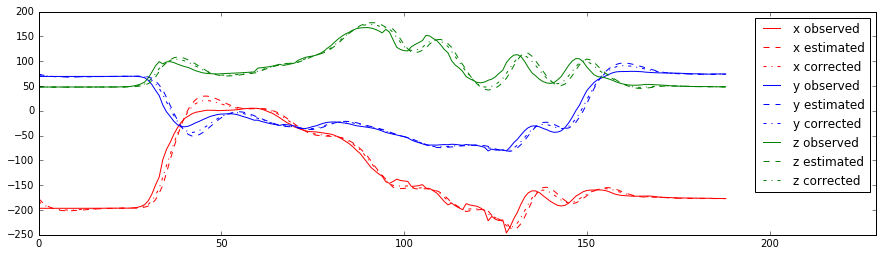

In [19]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,4))

plt.plot(observed['x'].values,"r-", label="x observed")
plt.plot(estimated['x'].values,"r--", label="x estimated")
plt.plot(corrected['x'].values,"r-.", label="x corrected")

plt.plot(observed['y'].values,"b-",label="y observed")
plt.plot(estimated['y'].values,"b--",label="y estimated")
plt.plot(corrected['y'].values,"b-.", label="y corrected")


plt.plot(observed['z'].values,"g-",label="z observed")
plt.plot(estimated['z'].values,"g--",label="z estimated")
plt.plot(corrected['z'].values,"g-.", label="z corrected")

plt.xlim(xmax=len(estimated)+40)
plt.legend()
plt.show()

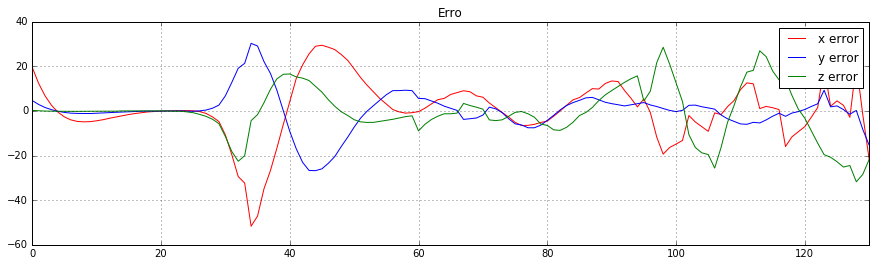

In [20]:
fig = plt.figure(figsize=(15,4))
plt.plot(estimated['x'].values-observed['x'].values,"r-", label="x error")
plt.plot(estimated['y'].values-observed['y'].values,"b-", label="y error")
plt.plot(estimated['z'].values-observed['z'].values,"g-", label="z error")
plt.xlim(xmax=130)
plt.legend()
plt.grid()
plt.title("Erro")
plt.show()